In [1]:

import nibabel as nib
import torch
from torch import nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from os.path import join as opj
import pandas as pd
import nltk
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('omw-1.4')

import tqdm
from torchsummary import summary
from PIL import Image

from sklearn.model_selection import train_test_split
import shutil
from scipy.stats import hypergeom
import seaborn as sns
from termcolor import colored
from sklearn.neighbors import NearestNeighbors
from torchvision.utils import make_grid
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
import nibabel.processing
import pickle
from scipy.io import loadmat
import numpy as np
import pandas as pd
import sklearn.preprocessing
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

from god_decoding_utils import *

from sklearn.metrics import classification_report

from torch import autocast
from diffusers import StableDiffusionPipeline
from diffusers import StableDiffusionImg2ImgPipeline

from PIL import Image
import ast

import wandb
from PIL import ImageFilter



[nltk_data] Downloading package wordnet to /home/matteo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/matteo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteoferrante. Use `wandb login --relogin` to force relogin


True

## Load the Data

In [3]:
sub="5"
roi="ROI_VC"
kamitani_data_mat=f"/home/matteo/data/fMRI/GOD/Subject{sub}.h5"
imagenet_dir="/home/matteo/data/fMRI/imagenet/images"

test_img_csv = '/home/matteo/data/fMRI/GOD/imageID_test.csv'
train_img_csv = '/home/matteo/data/fMRI/GOD/imageID_training.csv'
handler = data_handler(h5_file = kamitani_data_mat, test_img_csv =test_img_csv, train_img_csv =train_img_csv)
Y,Y_test,Y_test_avg = handler.get_data(normalize = 1, roi = roi)
labels_train, labels = handler.get_labels()
filenames_train,filenames_test=handler.get_filenames()

filenames_train=[i.item() for i in filenames_train]
filenames_test=[i.item() for i in filenames_test]

filenames_test_avg=[]
for i in range(50):
    filenames_test_avg.append(np.array(filenames_test)[labels==i][0])


In [4]:
config={"sub":sub, "roi": roi, "model": "ResNet50"}
wandb.init(project="BrainDecodingGOD", config=config)

### Handle wordnet (class) mapping

In [5]:
with open('class_to_wordnet.json',) as f:
    data = f.read()

class2wordnet = ast.literal_eval(data)
wordnet2class= {v["id"] : k for k,v in class2wordnet.items()}

In [6]:
wordnet_train=[f'{i.split("_")[0][1:]}-n' for i in filenames_train]



In [7]:
## Too many missing keys from wordnet map of imagenet classes and filenames, impossibile to recover the original labels

# mapped=[]
# missing=0
# for i in wordnet_train:
#     try:
#         m=wordnet2class[i]
#     except:
#         missing+=1
#         m=None
#     mapped.append(m)
# print(f"Missing {missing}")



In [8]:
img_dir_path="/home/matteo/data/fMRI/imagenet/images/train_dir/training"
image_paths=[os.path.join(img_dir_path,i) for i in filenames_train]

test_image_paths=[os.path.join(imagenet_dir,"test_dir","test",i) for i in filenames_test_avg]
fmri_train,fmri_val,image_train,image_val=train_test_split(Y,image_paths,test_size=0.1,random_state=42)

In [9]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])



transform=torchvision.transforms.Compose([torchvision.transforms.Resize(224),torchvision.transforms.ToTensor(),normalize])

train_dataset=CustomDataset(fmri_train,image_train,transform)
val_dataset=CustomDataset(fmri_val,image_val,transform)

test_dataset=CustomDataset(Y_test_avg,test_image_paths,transform)


train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=False)
val_dataloader=torch.utils.data.DataLoader(val_dataset,batch_size=64,shuffle=False)
test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=False)


In [10]:
model=torchvision.models.resnet50(pretrained=True)
modules=list(model.children())[:-1]
model=nn.Sequential(*modules)

In [11]:


## get the lantents
x_train=[]
z_train=[]
y_train=[]


x_val=[]
z_val=[]
y_val=[]

x_test=[]
z_test=[]
y_test=[]


with torch.no_grad():
    for x,y in tqdm.tqdm(train_dataloader):
        z=model(y)
        x_train.append(x)
        z_train.append(z.squeeze())
        y_train.append(y)
        
    for x,y in tqdm.tqdm(val_dataloader):
        z=model(y)
        x_val.append(x)
        z_val.append(z.squeeze())
        y_val.append(y)
    for x,y in tqdm.tqdm(test_dataloader):
        z=model(y)
        x_test.append(x)
        z_test.append(z.squeeze())
        y_test.append(y)
        
x_train=torch.cat(x_train,0).numpy()
z_train=torch.cat(z_train,0).numpy()
y_train=torch.cat(y_train,0).numpy()

x_val=torch.cat(x_val,0).numpy()
z_val=torch.cat(z_val,0).numpy()
y_val=torch.cat(y_val,0).numpy()

x_test=torch.cat(x_test,0).numpy()
z_test=torch.cat(z_test,0).numpy()
y_test=torch.cat(y_test,0).numpy()


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


## Load the Brain to Features Model

In [12]:
ridge = pickle.load(open(f"kamitani_models/ridge_sub{sub}.sav", 'rb'))

## Make predictions

In [13]:
test_predicted=ridge.predict(x_test)

epsilon=1e-10

std_norm_test_latent = (test_predicted - np.mean(test_predicted,axis=0)) / (epsilon+np.std(test_predicted,axis=0))
test_predicted_adj = std_norm_test_latent * np.std(z_train,axis=0) + np.mean(z_train,axis=0)

train_predicted=ridge.predict(x_train)
val_predicted=ridge.predict(x_val)




# print("r2",ridge.score(x_train,z_train))
# print("r2",r2_score(z_test,pred_instance))
# print("r2",r2_score(z_test,pred_test_latent))

print("rmse",mean_squared_error(z_train,train_predicted))
print("rmse",mean_squared_error(z_val,val_predicted))
print("rmse",mean_squared_error(z_test,test_predicted_adj))
print("rmse",mean_squared_error(z_test,test_predicted))


rmse 0.03804447930226393
rmse 0.2121011973390867
rmse 0.27996654996192805
rmse 0.1733106994970634


In [14]:
wandb.log({"ridge train rmse": mean_squared_error(z_train,train_predicted) , "ridge val rmse": mean_squared_error(z_val,val_predicted), "ridge test rmse" : mean_squared_error(z_test,test_predicted), "ridge test adj rmse": mean_squared_error(z_test,test_predicted_adj)})

## Evaluations

### Load ResNet50 Head, Feature Map and imagenet labels

In [15]:

# for vis
unnorm = torchvision.transforms.Compose([ torchvision.transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), torchvision.transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1.,1.,1.] )])


In [16]:
features_path="/home/matteo/fMRI_classification/captioning/features/feature_imagenet_500_resnet50.pt"
labels_path="/home/matteo/fMRI_classification/captioning/features/labels_imagenet_500_resnet50.pt"

In [17]:
features=torch.load(features_path)
labels=torch.load(labels_path)


In [18]:
### load labels, classifier and nearest neighbors

with open('classes.txt', 'rb') as handle:
    data_dict = handle.read()
idx2name= pickle.loads(data_dict)

## classifier head

clf=torchvision.models.resnet50(pretrained=True)
modules=list(clf.children())[-1:]
clf=nn.Sequential(*modules)

## neighbors
nbrs= NearestNeighbors(n_neighbors=5).fit(features.numpy())


### Predict plain classes with head and neighbors

In [19]:
# clf for brain (ridge on fmri) and model (resnet on images)

with torch.no_grad():
    clf_brain_train=clf(torch.Tensor(train_predicted))
    clf_model_train=clf(torch.Tensor(z_train))


    clf_brain_val=clf(torch.Tensor(val_predicted))
    clf_model_val=clf(torch.Tensor(z_val))

    clf_brain_test=clf(torch.Tensor(test_predicted))
    clf_model_test=clf(torch.Tensor(z_test))

    clf_brain_test_adj=clf(torch.Tensor(test_predicted_adj))
    clf_model_test_adj=clf(torch.Tensor(z_test)) #same as above





In [20]:
nbrs_brain_train=nbrs.kneighbors(train_predicted)
nbrs_model_train=nbrs.kneighbors(z_train)


In [21]:
## look for nearest neighbors (slow)


nbrs_brain_val=nbrs.kneighbors(val_predicted)
nbrs_model_val=nbrs.kneighbors(z_val)

nbrs_brain_test=nbrs.kneighbors(test_predicted)
nbrs_model_test=nbrs.kneighbors(z_test)

nbrs_brain_test_adj=nbrs.kneighbors(test_predicted_adj)
nbrs_model_test_adj=nbrs_model_test


In [22]:
## get the labels
nbrs_brain_train=labels[nbrs_brain_train[1]]
nbrs_model_train=labels[nbrs_model_train[1]]

nbrs_brain_val=labels[nbrs_brain_val[1]]
nbrs_model_val=labels[nbrs_model_val[1]]

nbrs_brain_test=labels[nbrs_brain_test[1]]
nbrs_model_test=labels[nbrs_model_test[1]]

nbrs_brain_test_adj=labels[nbrs_brain_test_adj[1]]
nbrs_model_test_adj=nbrs_model_test


In [23]:
def evaluate_topk(brain,model,k1=5,k2=5):
    acc={0:0,1:0,2:0,3:0,4:0,5:0}

    for i in range(len(brain)):
        
        n_un=len(torch.cat((torch.topk(brain[i],5).indices, torch.topk(model[i],5).indices)).unique())
        n_overlap=int(k1+k2)-n_un
        
        acc[n_overlap]+=1
        
#         if n_un==int(k1+k2):
#             acc+=0
    
#         else:
#             acc+=1
#     acc/=len(brain)

    for k in acc.keys():
        acc[k]/=len(brain)
    return acc
        

In [24]:
def evaluate_topk_nbrs(brain,model):
    acc={0:0,1:0,2:0,3:0,4:0,5:0}

    for i in range(len(brain)):
        
        
        t1=brain[i]
        t2=model[i]

        compareview = t2.repeat(t1.shape[0],1).T

        # Intersection
        intersection=t1[(compareview == t1).T.sum(1)==1]
        
        n_overlap=len(intersection)
        
        acc[n_overlap]+=1
        
#         if n_un==int(k1+k2):
#             acc+=0
    
#         else:
#             acc+=1
#     acc/=len(brain)

    for k in acc.keys():
        acc[k]/=len(brain)
    return acc
        

In [25]:
def top_5_acc(brain,model,k=5):
    
    acc=0
    for i in range(len(brain)):
        if model[i].argmax() in torch.topk(brain[i],k).indices:
            acc+=1
    return acc/len(brain)

In [26]:
def top_5_nbrs_acc(brain,model):
    acc=0
    for i in range(len(brain)):
        values,counts=nbrs_model_train[i].unique(return_counts=True)
        knn=values[counts.argmax()]
        
        if knn in brain[i]:
            acc+=1
    return acc/len(brain)

### top 1 accuracy

In [27]:
acc_clf_train_top=top_5_acc(clf_brain_train,clf_model_train)
acc_clf_val_top=top_5_acc(clf_brain_val,clf_model_val)
acc_clf_test_top=top_5_acc(clf_brain_test_adj,clf_model_test)


acc_nbrs_train_top=top_5_nbrs_acc(nbrs_brain_train,nbrs_model_train)
acc_nbrs_val_top=top_5_nbrs_acc(nbrs_brain_val,nbrs_model_val)
acc_nbrs_test_top=top_5_nbrs_acc(nbrs_brain_test_adj,nbrs_model_test)


print(f"[TOP 1] Resnet Head Classifier, Train acc: {acc_clf_train_top} Val acc: {acc_clf_val_top} Test acc: {acc_clf_test_top}")
print(f"[TOP 1] Neighbors Classifier, Train acc: {acc_nbrs_train_top} Val acc: {acc_nbrs_val_top} Test acc: {acc_nbrs_test_top}")


[TOP 1] Resnet Head Classifier, Train acc: 0.9907407407407407 Val acc: 0.03333333333333333 Test acc: 0.06
[TOP 1] Neighbors Classifier, Train acc: 0.8342592592592593 Val acc: 0.008333333333333333 Test acc: 0.0


In [28]:
wandb.log({"clf head top 1 train": acc_clf_train_top , "clf head top 1 val":acc_clf_val_top, "clf head top 1 test": acc_clf_test_top  })
wandb.log({"Nearest Neighbor top 1 train": acc_nbrs_train_top , "Nearest Neighbor top 1 val":acc_nbrs_val_top, "Nearest Neighbor top 1 test": acc_nbrs_test_top  })


#### top 5 of the brain model compared by top of image model and neighbors

In [29]:

acc_clf_train=evaluate_topk(clf_brain_train,clf_model_train)
acc_clf_val=evaluate_topk(clf_brain_val,clf_model_val)
acc_clf_test=evaluate_topk(clf_brain_test_adj,clf_model_test)

acc_nbrs_train=evaluate_topk_nbrs(nbrs_brain_train,nbrs_model_train)
acc_nbrs_val=evaluate_topk_nbrs(nbrs_brain_val,nbrs_model_val)
acc_nbrs_test=evaluate_topk_nbrs(nbrs_brain_test_adj,nbrs_model_test)

print(f"[TOP 5] Resnet Head Classifier, \n Train acc: {acc_clf_train} \n Val acc: {acc_clf_val} \nTest acc: {acc_clf_test} \n")
print(f"[TOP 5] Neighbors Classifier, \n Train acc: {acc_nbrs_train} \n Val acc: {acc_nbrs_val} \n Test acc: {acc_nbrs_test}")


[TOP 5] Resnet Head Classifier, 
 Train acc: {0: 0.0, 1: 0.002777777777777778, 2: 0.037037037037037035, 3: 0.16111111111111112, 4: 0.47962962962962963, 5: 0.3194444444444444} 
 Val acc: {0: 0.8916666666666667, 1: 0.09166666666666666, 2: 0.016666666666666666, 3: 0.0, 4: 0.0, 5: 0.0} 
Test acc: {0: 0.8, 1: 0.14, 2: 0.04, 3: 0.02, 4: 0.0, 5: 0.0} 

[TOP 5] Neighbors Classifier, 
 Train acc: {0: 0.575, 1: 0.22314814814814815, 2: 0.11666666666666667, 3: 0.06111111111111111, 4: 0.018518518518518517, 5: 0.005555555555555556} 
 Val acc: {0: 0.9833333333333333, 1: 0.008333333333333333, 2: 0.008333333333333333, 3: 0.0, 4: 0.0, 5: 0.0} 
 Test acc: {0: 0.98, 1: 0.0, 2: 0.02, 3: 0.0, 4: 0.0, 5: 0.0}


In [30]:
wandb.log({"clf head top 5 train": acc_clf_train , "clf head top 5 val":acc_clf_val, "clf head top 5 test": acc_clf_test  })
wandb.log({"Nearest Neighbor top 5 train": acc_nbrs_train , "Nearest Neighbor top 1 val":acc_nbrs_val, "Nearest Neighbor top 1 test": acc_nbrs_test  })


Text(0.5, 0, '# of matching between top5')

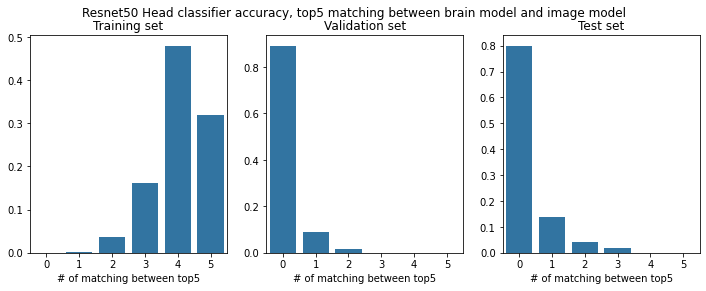

In [31]:
fig,axs=plt.subplots(1,3,figsize=(12,4))

fig.suptitle("Resnet50 Head classifier accuracy, top5 matching between brain model and image model")

sns.barplot(x=list(acc_clf_train.keys()),y=list(acc_clf_train.values()),ax=axs[0],color="tab:blue")
axs[0].set_title("Training set")
axs[0].set_xlabel("# of matching between top5")

sns.barplot(x=list(acc_clf_val.keys()),y=list(acc_clf_val.values()),ax=axs[1],color="tab:blue")
axs[1].set_title("Validation set")
axs[1].set_xlabel("# of matching between top5")

sns.barplot(x=list(acc_clf_test.keys()),y=list(acc_clf_test.values()),ax=axs[2],color="tab:blue")
axs[2].set_title("Test set")
axs[2].set_xlabel("# of matching between top5")



Text(0.5, 0, '# of matching nearest 5')

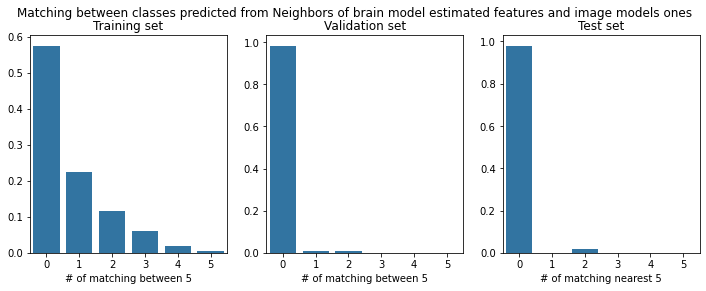

In [32]:
fig,axs=plt.subplots(1,3,figsize=(12,4))

fig.suptitle("Matching between classes predicted from Neighbors of brain model estimated features and image models ones")

sns.barplot(x=list(acc_nbrs_train.keys()),y=list(acc_nbrs_train.values()),ax=axs[0],color="tab:blue")
axs[0].set_title("Training set")
axs[0].set_xlabel("# of matching between 5")

sns.barplot(x=list(acc_nbrs_val.keys()),y=list(acc_nbrs_val.values()),ax=axs[1],color="tab:blue")
axs[1].set_title("Validation set")
axs[1].set_xlabel("# of matching between 5")

sns.barplot(x=list(acc_nbrs_test.keys()),y=list(acc_nbrs_test.values()),ax=axs[2],color="tab:blue")
axs[2].set_title("Test set")
axs[2].set_xlabel("# of matching nearest 5")



### WP similarity

for each image, recover the correspondent wordnet ID and synset. Then, compare with the classes predicted by the brain model through the WUP distance https://www.geeksforgeeks.org/nlp-wupalmer-wordnet-similarity/ 

$wup= 2* \frac{depth (lcs)}{depth(syn1)+depth(syn2)}$

In [33]:
def wordnet_to_synset(word_id):
    
    "take a wordnet id in form 2137123-n"
    s=wn.synset_from_pos_and_offset("n",int(word_id.split("-")[0]))
    return s

In [34]:
# wordnet.synset_from_pos_and_offset('n',2403454)

synset_train=[]
synset_val=[]
synset_test=[]

for img_name in image_train:
    id=img_name.split("/")[-1].split("_")[0]
    s=wn.synset_from_pos_and_offset("n",int(id[1:]))
    synset_train.append(s)
    
for img_name in image_val:
    id=img_name.split("/")[-1].split("_")[0]
    s=wn.synset_from_pos_and_offset("n",int(id[1:]))
    synset_val.append(s)
    
for img_name in test_image_paths:
    id=img_name.split("/")[-1].split("_")[0]
    s=wn.synset_from_pos_and_offset("n",int(id[1:]))
    synset_test.append(s)

# id=image_val[idx].split("/")[-1].split("_")[0]

# print(id)
# wn.synset_from_pos_and_offset("n",int(id[1:]))

# #lavorare qui, cercare i synset di tutti i dataset, le prediction e fare la metrica
# print(wn.synset_from_pos_and_offset("n",int(id[1:])))
# plt.imshow(torch.Tensor(y_val[idx]).permute(1,2,0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'goldfish.n.01')

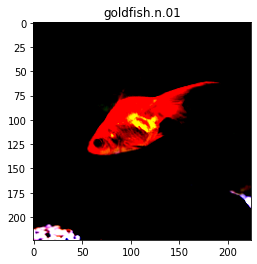

In [35]:
synset_test[0].name()
plt.imshow(torch.Tensor(y_test[0]).permute(1,2,0))
plt.title(synset_test[0].name())


In [36]:

#synset for best classifier output for brain features

clf_brain_synset_train=[wordnet_to_synset(class2wordnet[i.item()]["id"]) for i in clf_brain_train.argmax(dim=1)]
clf_brain_synset_val=[wordnet_to_synset(class2wordnet[i.item()]["id"]) for i in clf_brain_val.argmax(dim=1)]
clf_brain_synset_test=[wordnet_to_synset(class2wordnet[i.item()]["id"]) for i in clf_brain_test_adj.argmax(dim=1)]


In [37]:
## synset for nearest neighbor for brain features

nbrs_brain_synset_train=[wordnet_to_synset(class2wordnet[i[0].item()]["id"]) for i in nbrs_brain_train]
nbrs_brain_synset_val=[wordnet_to_synset(class2wordnet[i[0].item()]["id"]) for i in nbrs_brain_val]
nbrs_brain_synset_test=[wordnet_to_synset(class2wordnet[i[0].item()]["id"]) for i in nbrs_brain_test_adj]



In [38]:
train_clf_sim=[syn1.wup_similarity(syn2) for syn1,syn2 in zip(synset_train,clf_brain_synset_train)]
val_clf_sim=[syn1.wup_similarity(syn2) for syn1,syn2 in zip(synset_val,clf_brain_synset_val)]
test_clf_sim=[syn1.wup_similarity(syn2) for syn1,syn2 in zip(synset_test,clf_brain_synset_test)]

train_nbrs_sim=[syn1.wup_similarity(syn2) for syn1,syn2 in zip(synset_train,nbrs_brain_synset_train)]
val_nbrs_sim=[syn1.wup_similarity(syn2) for syn1,syn2 in zip(synset_val,nbrs_brain_synset_val)]
test_nbrs_sim=[syn1.wup_similarity(syn2) for syn1,syn2 in zip(synset_test,nbrs_brain_synset_test)]

In [39]:
print(f"WuPalmer Similarity for argmax of classifier, train: {np.mean(train_clf_sim):.4f} val: {np.mean(val_clf_sim):.4f} test: {np.mean(test_clf_sim):.4f}")
print(f"WuPalmer Similarity for nearest neighbor prediction, train: {np.mean(train_nbrs_sim):.4f} val: {np.mean(val_nbrs_sim):.4f} test: {np.mean(test_nbrs_sim):.4f}")


WuPalmer Similarity for argmax of classifier, train: 0.8182 val: 0.5532 test: 0.5531
WuPalmer Similarity for nearest neighbor prediction, train: 0.7820 val: 0.4996 test: 0.5633


In [40]:
wandb.log({"wup clf argmax train mean": np.mean(train_clf_sim),"wup clf argmax train std": np.std(train_clf_sim),
           "wup clf argmax val mean": np.mean(val_clf_sim),"wup clf argmax val std": np.std(val_clf_sim),
           "wup clf argmax test mean": np.mean(test_clf_sim),"wup clf argmax test std": np.std(test_clf_sim),
           "wup nbrs argmax train mean": np.mean(train_nbrs_sim),"wup nbrs argmax train std": np.std(train_nbrs_sim),
           "wup nbrs argmax val mean": np.mean(val_nbrs_sim),"wup nbrs argmax val std": np.std(val_nbrs_sim),
           "wup nbrs argmax test mean": np.mean(test_nbrs_sim),"wup nbrs argmax test std": np.std(test_nbrs_sim)
           
          })

#### Some references to understand the values of WUP

In [41]:
## reference value

couples=[("apple","pear"), ("apple","fruit"), ("apple", "food"), ("apple", "home"), ("apple", "life"), ("apple", "school")]

for n1, n2 in couples:
    syn1 = wn.synsets(n1)[0]
    syn2 = wn.synsets(n2)[0]

    sim=syn1.wup_similarity(syn2)
    
    print(f"wup similarity between {n1} and {n2} is {sim:.3f}")

wup similarity between apple and pear is 0.909
wup similarity between apple and fruit is 0.900
wup similarity between apple and food is 0.462
wup similarity between apple and home is 0.316
wup similarity between apple and life is 0.143
wup similarity between apple and school is 0.125


#### Extend WUP to 5 nearest neighbors

In [42]:
nbrs_brain_synset_train_all=[]
nbrs_brain_synset_val_all=[]
nbrs_brain_synset_test_all=[]

for i in nbrs_brain_train:
    nbrs_brain_synset_train_all.append([wordnet_to_synset(class2wordnet[j.item()]["id"]) for j in i])
    

for i in nbrs_brain_val:
    nbrs_brain_synset_val_all.append([wordnet_to_synset(class2wordnet[j.item()]["id"]) for j in i])
    
    
for i in nbrs_brain_test:
    nbrs_brain_synset_test_all.append([wordnet_to_synset(class2wordnet[j.item()]["id"]) for j in i])

In [43]:
train_nbrs_sim_all=[]
val_nbrs_sim_all=[]
test_nbrs_sim_all=[]

for i in range(len(nbrs_brain_synset_train_all)):
    a=[]
    syn1=synset_train[i]
    for j in range(5):
        syn2=nbrs_brain_synset_train_all[i][j]
        a.append(syn1.wup_similarity(syn2))
    train_nbrs_sim_all.append(a)

for i in range(len(nbrs_brain_synset_val_all)):
    a=[]
    syn1=synset_val[i]
    for j in range(5):
        syn2=nbrs_brain_synset_val_all[i][j]
        a.append(syn1.wup_similarity(syn2))
    val_nbrs_sim_all.append(a)

for i in range(len(nbrs_brain_synset_test_all)):
    a=[]
    syn1=synset_test[i]
    for j in range(5):
        syn2=nbrs_brain_synset_test_all[i][j]
        a.append(syn1.wup_similarity(syn2))
    test_nbrs_sim_all.append(a)

In [44]:
print(f"WuPalmer Similarity for 5 nearest neighbors (average) of classifier, train: {np.mean(train_nbrs_sim_all):.4f} val: {np.mean(val_nbrs_sim_all):.4f} test: {np.mean(test_nbrs_sim_all):.4f}")


WuPalmer Similarity for 5 nearest neighbors (average) of classifier, train: 0.7631 val: 0.5135 test: 0.4873


### random example

Text(0.5, 1.0, 'model best guess: screwdriver;  brain best guess screwdriver')

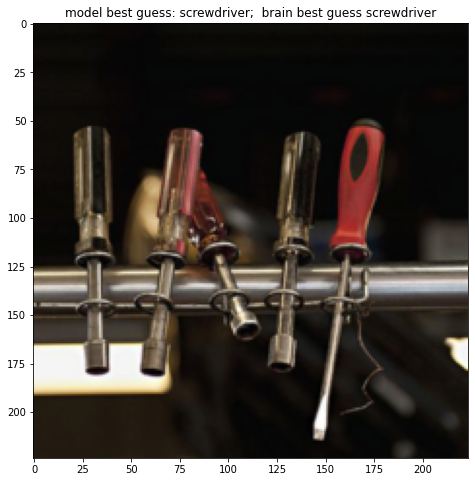

In [45]:
r=np.random.randint(len(z_val))

fig,axs=plt.subplots(1,figsize=(8,8))

axs.imshow(unnorm(torch.Tensor(y_val[r])).permute(1,2,0))
axs.set_title(f"model best guess: {idx2name[clf_model_val[r].argmax().item()]};  brain best guess {idx2name[nbrs_model_val[r][0].item()]}")

### Evaluation 1. Top 5 prediction from brain model vs Top 1 Pre-trained model

## Plain Reconstructions

In [46]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", use_auth_token=True)
pipe = pipe.to("cuda")



Downloading:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [47]:
def generate_images(labels):
    prompt=[f"An image of a {label}" for label in labels]
    generated= pipe(prompt)
    return generated.images

In [48]:
clf_generated=[]
nbrs_generated=[]

for r in range(len(y_test)):
    clf_labels=[idx2name[i.item()] for i in torch.topk(clf_brain_test[r],5).indices]
    clf_generated.append(generate_images(clf_labels))
    print(f"CLF {r}/{len(y_test)}")
    
for r in range(len(y_test)):
    nbrs_labels=[idx2name[i.item()] for i in nbrs_brain_test_adj[r]]
    nbrs_generated.append(generate_images(nbrs_labels))
    print(f"NBRS {r}/{len(y_test)}")

    

  0%|          | 0/51 [00:00<?, ?it/s]

CLF 0/50


  0%|          | 0/51 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


CLF 1/50


  0%|          | 0/51 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


CLF 2/50


  0%|          | 0/51 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


CLF 3/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 4/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 5/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 6/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 7/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 8/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 9/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 10/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 11/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 12/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 13/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 14/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 15/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 16/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 17/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 18/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 19/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 20/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 21/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 22/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 23/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 24/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 25/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 26/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 27/50


  0%|          | 0/51 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


CLF 28/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 29/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 30/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 31/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 32/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 33/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 34/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 35/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 36/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 37/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 38/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 39/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 40/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 41/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 42/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 43/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 44/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 45/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 46/50


  0%|          | 0/51 [00:00<?, ?it/s]

CLF 47/50


  0%|          | 0/51 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


CLF 48/50


  0%|          | 0/51 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


CLF 49/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 0/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 1/50


  0%|          | 0/51 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


NBRS 2/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 3/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 4/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 5/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 6/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 7/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 8/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 9/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 10/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 11/50


  0%|          | 0/51 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


NBRS 12/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 13/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 14/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 15/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 16/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 17/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 18/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 19/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 20/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 21/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 22/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 23/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 24/50


  0%|          | 0/51 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


NBRS 25/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 26/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 27/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 28/50


  0%|          | 0/51 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


NBRS 29/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 30/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 31/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 32/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 33/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 34/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 35/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 36/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 37/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 38/50


  0%|          | 0/51 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


NBRS 39/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 40/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 41/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 42/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 43/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 44/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 45/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 46/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 47/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 48/50


  0%|          | 0/51 [00:00<?, ?it/s]

NBRS 49/50


### show ten images

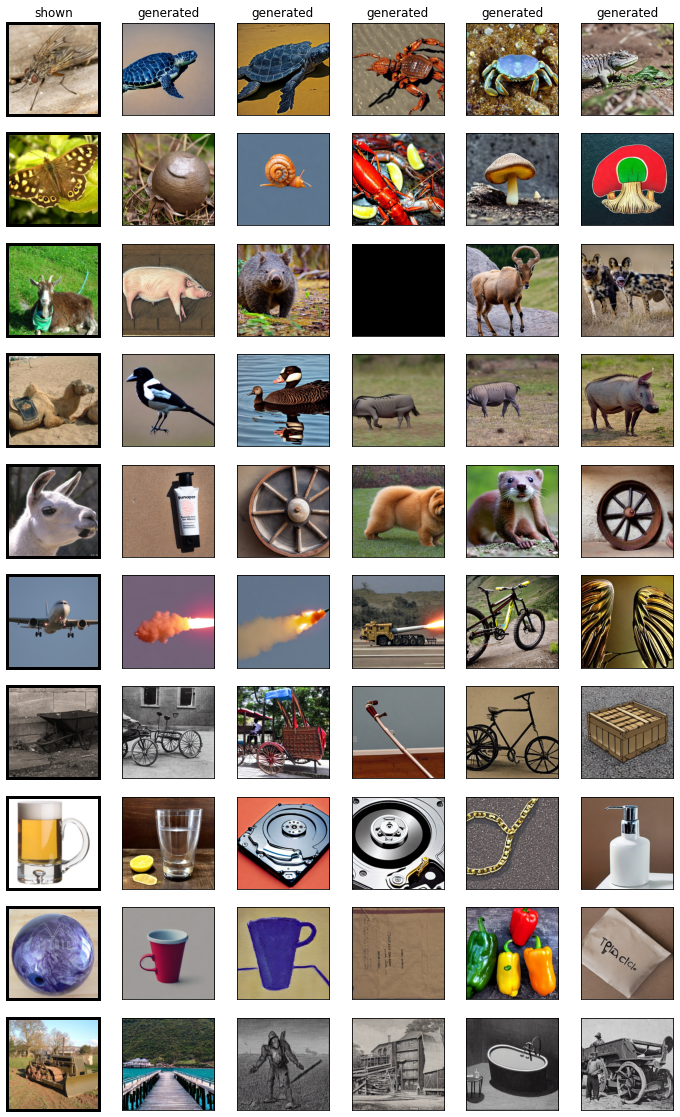

In [49]:
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False

fig, axs =plt.subplots(10,6, figsize=(12,20))

offset=10
for j in range(offset,offset+10):
    axs[j-offset,0].imshow(unnorm(torch.Tensor(y_test[j])).permute(1,2,0))
    [x.set_linewidth(3) for x in axs[j-offset,0].spines.values()]

    for i in range(5):
        axs[j-offset,i+1].imshow(nbrs_generated[j][i])
        
axs[0,0].set_title("shown")
for i in range(5):
    axs[0,i+1].set_title("generated")


## Save on Wandb

In [50]:
table = wandb.Table(columns=['Shown','Ridge_0', 'Ridge_1',"Ridge_2","Ridge_3","Ridge_4"])


In [51]:
for i in range(len(y_test)):
    imgs=(wandb.Image(x) for x in nbrs_generated[i])
    table.add_data(wandb.Image(unnorm(torch.Tensor(y_test[i])).permute(1,2,0).numpy()), *imgs)
    

In [52]:
wandb.log({"table":table})

### Random Example

['hair slide', 'wool, woolen, woollen', 'Granny Smith', 'wooden spoon', 'fig']
['bell pepper', 'hair slide', 'broccoli', 'acorn', 'acorn']
['conch', 'hermit crab', 'chiton, coat-of-mail shell, sea cradle, polyplacophore', 'snail', 'jellyfish']


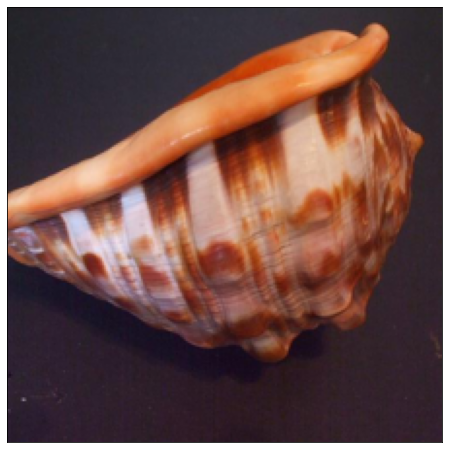

In [53]:
r=np.random.randint(len(test_predicted))
print([idx2name[i.item()] for i in torch.topk(clf_brain_test_adj[r],5).indices])

print([idx2name[i.item()] for i in nbrs_brain_test_adj[r]])
print([idx2name[i.item()] for i in torch.topk(clf_model_test[r],5).indices])

fig,axs=plt.subplots(1,figsize=(8,8))

axs.imshow(unnorm(torch.Tensor(y_test[r])).permute(1,2,0))

### Neighbors prompt

In [54]:

nbrs_prompt=[f"An image of a {idx2name[i.item()]}" for i in nbrs_brain_test_adj[r]]
nbrs_image= pipe(nbrs_prompt)

  0%|          | 0/51 [00:00<?, ?it/s]

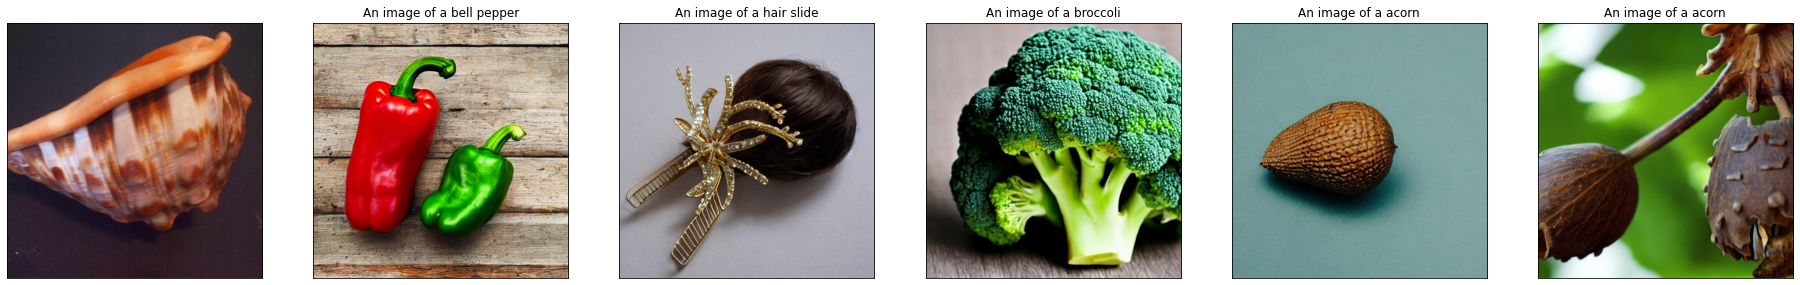

In [55]:
fig,axs=plt.subplots(1,6,figsize=(32,8))

axs[0].imshow(unnorm(torch.Tensor(y_test[r])).permute(1,2,0))
for i in range(5):
    axs[i+1].imshow(nbrs_image.images[i])
    axs[i+1].set_title(nbrs_prompt[i])

### Clf prompt

In [ ]:


clf_prompt=[f"An image of a {idx2name[i.item()]}" for i in torch.topk(clf_brain_test_adj[r],5).indices]
clf_image= pipe(clf_prompt)

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
fig,axs=plt.subplots(1,6,figsize=(32,8))

axs[0].imshow(unnorm(torch.Tensor(y_test[r])).permute(1,2,0))
for i in range(5):
    axs[i+1].imshow(clf_image.images[i])
    axs[i+1].set_title(clf_prompt[i])


## Load Autoencoder and brain to latent model

In [ ]:
class ConvEncoder(nn.Module):
    def __init__(self,conv_channels=[32,64,128],bn=False,latent_dim=512,final_dim=4):
        super().__init__()
        self.latent_dim=latent_dim
        conv_layers=[]
        for c in conv_channels:
            conv_layers.append(nn.LazyConv2d(out_channels=c,kernel_size=4,stride=2,padding=1))
            if bn:
                conv_layers.append(nn.BatchNorm2d(c))
            conv_layers.append(nn.GELU())
        conv_layers.append(nn.AdaptiveAvgPool2d(final_dim))
        conv_layers.append(nn.Flatten())
        
        conv_layers.append(nn.LazyLinear(latent_dim))
        self.model=nn.Sequential(*conv_layers)
        
    
    def forward(self,x):
        return self.model(x)
            
        
class ConvDecoder(nn.Module):
    def __init__(self,conv_channels=[64,32,16],out_channels=1,bn=False,latent_dim=512,target_side=96):
        super().__init__()
        conv_layers=[]
        
        self.downsampled_side=target_side//2**len(conv_channels)
        self.predecoder=nn.LazyLinear(conv_channels[0]*self.downsampled_side**2)
        
        
        for c in conv_channels:
            conv_layers.append(nn.LazyConvTranspose2d(out_channels=c,kernel_size=4,stride=2,padding=1))
            if bn:
                conv_layers.append(nn.BatchNorm2d(c))
            conv_layers.append(nn.GELU())
        
        conv_layers.append(nn.LazyConvTranspose2d(out_channels=out_channels,kernel_size=3,stride=1,padding=1))
        conv_layers.append(nn.Sigmoid())
        self.model=nn.Sequential(*conv_layers)
    
    def forward(self,x):
        
        #reshape features
        bs=x.shape[0]
        x=self.predecoder(x)
        x=x.view(bs,-1,self.downsampled_side,self.downsampled_side)
        
        return self.model(x)        
    
    
class AE(nn.Module):
    def __init__(self,encoder,decoder):
        super().__init__()
        self.encoder=encoder
        self.decoder=decoder
        
        
    def forward(self,x):
        
        z=self.encoder(x)
        x2=self.decoder(z)
        
        return x2

In [ ]:
side_dim=96
latent_dim=1024
config={}
config["model"]="ae_perceptual"
config["encoder_channels"]=[64,128,128,256]
config["decoder_channels"]=[128,128,64,32]
config["latent_dim"]=latent_dim
config["side_dim"]=side_dim



e=ConvEncoder(conv_channels=config["encoder_channels"],bn=True,latent_dim=config["latent_dim"])
d=ConvDecoder(conv_channels=config["decoder_channels"],out_channels=3,bn=True,latent_dim=config["latent_dim"],target_side=config["side_dim"])


model_ae=AE(encoder=e,decoder=d)

summary(model_ae.encoder,(3,side_dim,side_dim),device="cpu")
summary(model_ae.decoder,(latent_dim,),device="cpu")


model_ae.load_state_dict(torch.load("models/ae_imagenet/ae_imagenet.pt"))

## Make initial Guess

In [ ]:
h_train=[]
h_val=[]
h_test=[]

with torch.no_grad():
    for y in tqdm.tqdm(y_train):
        h=model_ae.encoder(torch.Tensor(y).unsqueeze(0))
        h_train.append(h)

    for y in tqdm.tqdm(y_val):
        h=model_ae.encoder(torch.Tensor(y).unsqueeze(0))
        h_val.append(h)

    for y in tqdm.tqdm(y_test):
        h=model_ae.encoder(torch.Tensor(y).unsqueeze(0))
        h_test.append(h)

h_train=torch.stack(h_train).squeeze().numpy()
h_val=torch.stack(h_val).squeeze().numpy()
h_test=torch.stack(h_test).squeeze().numpy()


In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
ridge_ae=Ridge(alpha=1000)
# ridge_ae=MLPRegressor()

ridge_ae.fit(x_train,h_train)


h_train_predicted=ridge_ae.predict(x_train)
h_val_predicted=ridge_ae.predict(x_val)

h_test_predicted=ridge_ae.predict(x_test)


std_norm_test_latent = (h_test_predicted - np.mean(h_test_predicted,axis=0)) / np.std(h_test_predicted,axis=0)
h_test_predicted_adj = std_norm_test_latent * np.std(h_train,axis=0) + np.mean(h_train,axis=0)


# print("r2",ridge.score(x_train,z_train))
# print("r2",r2_score(z_test,pred_instance))
# print("r2",r2_score(z_test,pred_test_latent))

print("rmse",mean_squared_error(h_train,h_train_predicted))
print("rmse",mean_squared_error(h_val,h_val_predicted))

print("rmse",mean_squared_error(h_test,h_test_predicted))
print("rmse",mean_squared_error(h_test,h_test_predicted_adj))

In [ ]:
def adjust_test_h(h_pred,h_test_predicted=h_test_predicted,h_train=h_train):
    std_norm_test_latent = (h_pred - np.mean(h_test_predicted,axis=0)) / np.std(h_test_predicted,axis=0)
    h_adj = std_norm_test_latent * np.std(h_train,axis=0) + np.mean(h_train,axis=0)
    return h_adj

## random initial guess

In [ ]:
r=np.random.randint(len(h_test))

fig,axs=plt.subplots(1,2,figsize=(8,8))

axs[0].imshow(unnorm(torch.Tensor(y_test[r])).permute(1,2,0))


## decode

h_pred=ridge_ae.predict([x_test[r]])
h_pred_adj=adjust_test_h(h_pred)

with torch.no_grad():
    decoded_img=model_ae.decoder(torch.Tensor(h_pred_adj).unsqueeze(0))

axs[1].imshow(decoded_img[0].permute(1,2,0))
# axs.set_title(f"model best guess: {idx2name[clf_model_val[r].argmax().item()]};  brain best guess {idx2name[nbrs_model_val[r][0].item()]}")

## Reconstructions from initial guess

In [ ]:
pipe_img= StableDiffusionImg2ImgPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", revision="fp16" ,use_auth_token=True)

In [ ]:
to_pil=torchvision.transforms.ToPILImage()

In [ ]:
init_image=to_pil(decoded_img[0])
init_image = init_image.resize((128, 128)).filter(ImageFilter.MedianFilter(21))

nbrs_prompt=[f"An image of a {idx2name[i.item()]}" for i in nbrs_brain_test_adj[r]]


images = pipe_img(prompt=nbrs_prompt, init_image=init_image, strength=0.5, guidance_scale=7.5)


In [ ]:
fig,axs=plt.subplots(1,7,figsize=(32,8))

axs[0].imshow(unnorm(torch.Tensor(y_test[r])).permute(1,2,0))
axs[1].imshow(init_image)

for i in range(5):
    axs[i+2].imshow(images.images[i])
    axs[i+2].set_title(nbrs_prompt[i])

In [ ]:
init_image=to_pil(decoded_img[0])
init_image = init_image.resize((128, 128)).filter(ImageFilter.MedianFilter(21))
init_image